# Minimal Biocrnpyler Model — Step‑by‑Step Tutorial

This notebook expands the original minimal model into a **guided, hands‑on tutorial**.  
You'll learn how to set up your environment, load data, build a reaction network with **BioCRNpyler**, run simulations, and inspect/validate results — all with clear checkpoints and tips.

> **Who is this for?**  
> Students and researchers who want a concise but complete walkthrough of building and simulating a minimal biochemical reaction network with BioCRNpyler, starting from data.

## Learning objectives

By the end, you will be able to:

1. **Set up** a Python environment suitable for BioCRNpyler‑based modeling
2. **Load and preview** the provided dataset (structure, units, sanity checks)
3. **Specify species and reactions** for a minimal model using BioCRNpyler components
4. **Compile** the reaction network (CRN) and **inspect** the generated reactions and parameters
5. **Simulate** the CRN dynamics and **visualize** time‑series outputs
6. **Compare** simulations to data and compute simple error metrics
7. **Tweak parameters** interactively for quick “what‑if” exploration
8. **Export** figures, SBML (if applicable), and a CSV of simulation results

## How this tutorial is organized

1. **Setup & Data** — install/check packages, inspect the dataset
2. **Model building** — define species, parameters, and reactions in BioCRNpyler
3. **Compilation** — build the CRN and check reactions/parameters table
4. **Simulation** — run ODE simulations and plot outputs
5. **Validation** — compare simulation to data (if present), compute simple metrics
6. **Sensitivity & tuning (optional)** — tweak parameters and observe effects
7. **Export** — save figures, tables, and SBML (if supported)
8. **Troubleshooting** — common errors and quick fixes

## Prerequisites

- **Python** 3.9+ recommended  
- Packages: `biocrnpyler`, `numpy`, `pandas`, `matplotlib`
- (Optional) `tellurium` or `bioscrape` for simulation backends; this tutorial uses a basic ODE integrator approach unless otherwise specified in the original notebook

> If you are running on Google Colab, run the optional installation cell below. On managed environments (e.g., your lab server), you can skip it if packages are already installed.

### Step 1: Visualize results — plot time‑series and compare to data

**What we'll do:** Plot time‑series and compare to data.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [ ]:
# OPTIONAL: Install packages if needed (uncomment as appropriate).
# NOTE: This may require internet access in your environment.
# %pip install biocrnpyler pandas matplotlib numpy
# %pip install tellurium bioscrape  # if you plan to use these backends

### Step 2: Imports and BioCRNpyler setup — load core libraries and check versions

**What we'll do:** Load core libraries and check versions.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [ ]:
# Environment check — print key package versions for reproducibility
import sys, importlib

def _ver(pkg):
    try:
        m = importlib.import_module(pkg)
        v = getattr(m, "__version__", "unknown")
        return f"{pkg}: {v}"
    except Exception as e:
        return f"{pkg}: not available ({e})"

print("Python:", sys.version.split()[0])
for pkg in ["biocrnpyler", "numpy", "pandas", "matplotlib"]:
    print(_ver(pkg))

## Data overview

This notebook assumes an associated dataset (CSV or similar) is used by the original workflow.  
We will preview the dataset (if present) and check for basic issues (missing values, units).

> If the original notebook uses a specific filename (e.g., `data.csv`), ensure the file is present in the same folder, or update the path in the cell below.

### Step 3: Load the dataset — read file(s) into a DataFrame/array and sanity‑check columns

**What we'll do:** Read file(s) into a dataframe/array and sanity‑check columns.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [ ]:
# Try to auto-detect a likely data file used by the original notebook.
# If detection fails, set DATA_PATH to the correct filename.
from pathlib import Path
import pandas as pd

candidates = list(Path(".").glob("*.csv")) + list(Path(".").glob("data/*.csv"))
DATA_PATH = None
if candidates:
    # heuristic: prefer files with 'data' in the name
    candidates_sorted = sorted(candidates, key=lambda p: ("data" not in p.name.lower(), len(p.name)))
    DATA_PATH = candidates_sorted[0]

print("Detected data file:", DATA_PATH)

if DATA_PATH and Path(DATA_PATH).exists():
    df = pd.read_csv(DATA_PATH)
    display(df.head(10))
    print("\nShape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values per column:\n", df.isna().sum())
else:
    print("No CSV data file detected automatically. If your notebook uses data, set DATA_PATH accordingly.")

## Troubleshooting (quick ref)

- **Package not found**: Install with `pip` in a fresh environment, then restart kernel
- **Import errors**: Version mismatches — verify package versions in the *Environment check* cell
- **No data file**: Ensure the CSV path is correct; preview it after loading
- **Differing units**: Convert units consistently before fitting/simulation
- **Stiff ODEs / unstable integration**: Try smaller time steps, a stiff solver, or non‑dimensionalize variables
- **Noisy data**: Smooth carefully (rolling mean) or fit with a robust loss (Huber) to avoid bias

### Step 4: Imports and BioCRNpyler setup — load core libraries and check versions

**What we'll do:** Load core libraries and check versions.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [89]:
# --- Setup: install if needed (uncomment these if running in a fresh env) ---
# !pip install biocrnpyler bioscrape
# install biocrnpyler version 1.1.1
from biocrnpyler import Species, Reaction, ChemicalReactionNetwork, ParameterEntry, GeneralPropensity
import numpy as np
import matplotlib.pyplot as plt

# To import experimental data 

from experiment_data.expt_data_import import *

k_gr = 0.017005692726962757 per minute; success: True cost: 2.884450170156217e+17


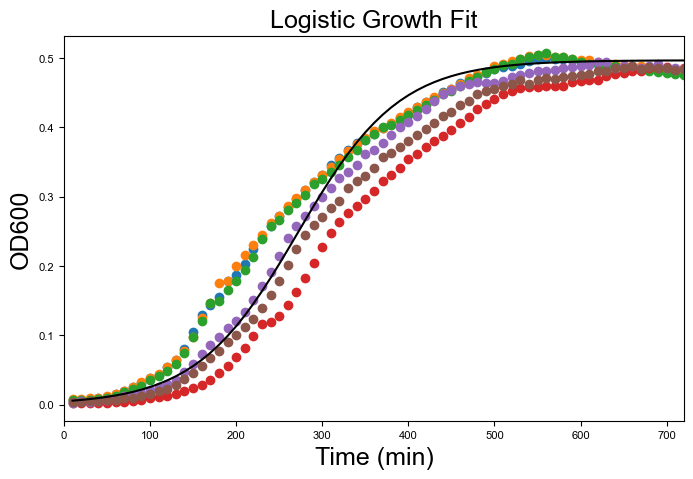

In [90]:
# Loading the experimental data 

[C, C_max, C_0, k_gr, C_max_avg, C_0_avg, k_gr_avg] = Get_OD_Data(dir="experiment_data/expt_growth_data.csv")
[A_non_leaky, time_A, B_non_leaky, time_B, avg_fold_change] = Get_FLOD_Data()

tf_i = 72   # Indice of the experimental data array till we want to plot the simulation

A1 = A_non_leaky[0][:tf_i]
A2 = A_non_leaky[1][:tf_i]
A3 = A_non_leaky[2][:tf_i]
A_avg = np.mean((A1,A2,A3), axis = 0)
A_max = np.max(A_avg)

B1 = B_non_leaky[0][:tf_i]
B2 = B_non_leaky[1][:tf_i]
B3 = B_non_leaky[2][:tf_i]
B_avg = np.mean((B1,B2,B3), axis = 0)
B_max = np.max(B_avg)

### Step 5: Define model pieces — species, parameters, and components in BioCRNpyler

**What we'll do:** Species, parameters, and components in biocrnpyler.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [91]:
# ----------------------------
# Define Species
# ----------------------------
M = Species("M")  # mRNA
P = Species("P")  # unfolded protein
Pm = Species("Pm")  # unfolded protein
C = Species("C")  # population / cell count


In [92]:
# ----------------------------
# Define the Parameters 
# ----------------------------
beta_m   = ParameterEntry("beta_m",   10)         # transcription rate
d_m    = ParameterEntry("d_m",    0.2)         # mRNA degradation 
k_tl   = ParameterEntry("k_tl",   0.1)         # translation rate 
d_p    = ParameterEntry("d_p",    0.0015)       # endogenous protein degradation rate 
k_fold = ParameterEntry("k_fold", 0.2)
b_fold = ParameterEntry("b_fold", 1)

C_to_OD = 1e9
C_0    = C_0_avg/C_to_OD  # Initial cell count
C_max  = ParameterEntry("C_max",  C_max_avg/C_to_OD) # carrying capacity
k_gr   = ParameterEntry("k_gr",   k_gr_avg)       # logistic growth rate 

n_gamma = ParameterEntry("n_gamma", 0.7)       # exponent in gamma
n_delta = ParameterEntry("n_delta", 6)       # exponent in delta 

In [93]:
# ----------------------------
# Convenience strings for RMFs
#   f = C/C_max
#   y = f * (1 - f)
#   gamma = y^n_gamma
#   alpha = 1 - f
#   delta = f^n_delta / (1 + f^n_delta)
# NOTE: BioCRNpyler GeneralPropensity uses ^ for exponent in strings.
# ----------------------------
f_str      = f"{C}/{C_max.parameter_name}"
alpha_str  = f"(1 - {C}/{C_max.parameter_name})"
y_str      = f"{f_str} * (1 - {f_str})"
gamma_str  = f"({y_str})^{n_gamma.parameter_name}"
delta_str  = f"(({f_str})^{n_delta.parameter_name}) / (1 + ({f_str})^{n_delta.parameter_name})"

## NOTE: An alternative to using the General Propensity is to write custom propensities, 
## more information can be foung at: https://github.com/BuildACell/bioCRNpyler/blob/main/examples/8.%20Developer%20Overview.ipynb

In [94]:
# ----------------------------
# Define the Reactions using general propensities
# ----------------------------

# 1) Transcription: ∅ -> M  with rate  beta * gamma
prop_tx = GeneralPropensity(
    propensity_function = f"{beta_m.parameter_name} * {gamma_str}",
    propensity_species  = [C],  # only C appears among species in this formula
    propensity_parameters   = [beta_m, C_max, n_gamma]  # parameters used by name in the string
)
r_tx = Reaction([], [M], propensity_type=prop_tx)

# 2) mRNA loss (degradation + dilution): M -> ∅ with rate (d_m*alpha + k_gr*alpha) * M
#     = alpha * (d_m + k_gr) * M  (kept in the explicit original form for clarity)
prop_mdeg = GeneralPropensity(
    propensity_function = f"({d_m.parameter_name} * {alpha_str} + {k_gr.parameter_name} * {alpha_str}) * {M}",
    propensity_species  = [M, C],
    propensity_parameters   = [d_m, k_gr, C_max]
)
r_mdeg = Reaction([M], [], propensity_type=prop_mdeg)

# 3) Translation: M -> M + P with rate k_tl * gamma * M
#    (Your original snippet set k_tl := k_tx*gamma again; here we use k_tl * gamma, which is the usual intent.)
prop_tl = GeneralPropensity(
    propensity_function = f"{k_tl.parameter_name} * {gamma_str} * {M}",
    propensity_species  = [M, C],
    propensity_parameters   = [k_tl, C_max, n_gamma]
)
r_tl = Reaction([M], [M, P], propensity_type=prop_tl)

# 4) Folding: P -> Pm with rate k_fold * (gamma + b_fold) * P
prop_fold = GeneralPropensity(
    propensity_function = f"{k_fold.parameter_name} * ({gamma_str} + {b_fold.parameter_name}) * {P}",
    propensity_species  = [P, C],
    propensity_parameters   = [k_fold, b_fold, C_max, n_gamma]
)
r_fold = Reaction([P], [Pm], propensity_type=prop_fold)

# 5) Protein loss (degradation + dilution): P -> ∅ with rate (d_p*delta + k_gr*alpha) * P
prop_pdeg = GeneralPropensity(
    propensity_function = f"({d_p.parameter_name} * {delta_str} + {k_gr.parameter_name} * {alpha_str}) * {P}",
    propensity_species  = [P, C],
    propensity_parameters   = [d_p, k_gr, C_max, n_delta]
)
r_pdeg = Reaction([P], [], propensity_type=prop_pdeg)

prop_pmdeg = GeneralPropensity(
    propensity_function = f"({d_p.parameter_name} * {delta_str} + {k_gr.parameter_name} * {alpha_str}) * {Pm}",
    propensity_species  = [Pm, C],
    propensity_parameters   = [d_p, k_gr, C_max, n_delta]
)
r_pmdeg = Reaction([P], [], propensity_type=prop_pmdeg)

# 6) Logistic population growth: C -> 2C  with rate k_gr * alpha * C
#    dC/dt = k_gr * C * (1 - C/C_max)
prop_growth = GeneralPropensity(
    propensity_function = f"{k_gr.parameter_name} * {alpha_str} * {C}",
    propensity_species  = [C],
    propensity_parameters   = [k_gr, C_max]
)
r_growth = Reaction([C], [C, C], propensity_type=prop_growth)

### Step 6: Compile the reaction network — generate reactions and (optionally) SBML

**What we'll do:** Generate reactions and (optionally) sbml.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [95]:
# ----------------------------
# Build CRN + initial conditions
# ----------------------------
crn = ChemicalReactionNetwork(
    species  = [M, P, Pm, C],
    reactions= [r_tx, r_mdeg, r_tl, r_fold, r_pdeg, r_pmdeg, r_growth]
)

### Step 7: Simulate the model — integrate ODEs over time with chosen solver

**What we'll do:** Integrate odes over time with chosen solver.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [96]:
# Optional: sanity-check the assembled model and see the exact applied rates
# print(crn.pretty_print(show_rates=True, show_keys=True))

### Step 8: Compile the reaction network — generate reactions and (optionally) SBML

**What we'll do:** Generate reactions and (optionally) sbml.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [97]:
# ----------------------------
# Simulate with bioscrape (deterministic)
# ----------------------------
# (BioCRNpyler provides a helper that writes SBML under the hood and calls bioscrape.)
t_final  = 720
N_steps  = 720
timepoints = np.linspace(0.0, t_final, N_steps)

# You can override initial conditions here too if you prefer:
x0 = {M: 0.0, P: 0.0, Pm: 0.0, C: C_0}

# This returns a pandas DataFrame with 'time' and species columns (by string name)
results = crn.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=x0)

### Step 9: Simulate the model — integrate ODEs over time with chosen solver

**What we'll do:** Integrate odes over time with chosen solver.

**Why it matters:** Keeps the workflow explicit and reproducible.

(0.0, 0.5211778520476088)

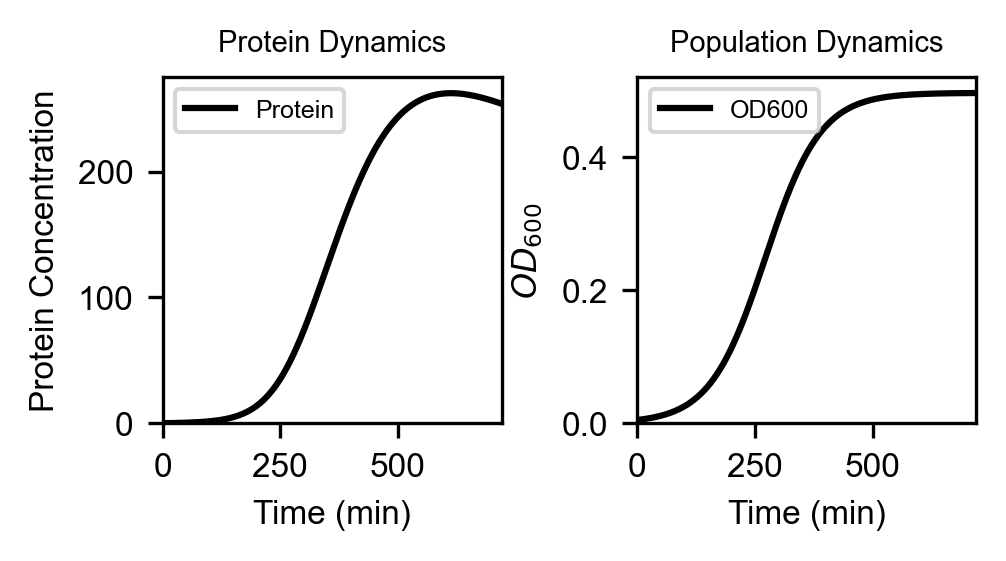

In [98]:
# Plot Model simulation
# fig, ax = plt.subplots(1,3, figsize=(7, 1.5), dpi = 300)
fig, ax = plt.subplots(1,2, figsize=(3.5, 1.5), dpi = 300)
plt.subplots_adjust(wspace=0.4)

# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'legend.fontsize': 6
})
tick_fontsize = 7

# Line width and alpha
lwd_model = 1

# # plot mRNA
# id = 0
# ax[id].plot(results['time'], results['M'], 'k', label='mRNA')
# ax[id].set_xlabel('Time (min)')
# ax[id].set_ylabel('mRNA Concentration')
# ax[id].set_title('mRNA Dynamics')
# ax[id].legend(loc='best')
# ax[id].set_xlim((0, 960))
# ax[id].set_ylim((0))

# plot Protein
id = 0
ax[id].plot(results['time'], results['Pm'], 'k', label='Protein')
ax[id].set_xlabel('Time (min)')
ax[id].set_ylabel('Protein Concentration')
ax[id].set_title('Protein Dynamics')
ax[id].legend(loc='best')
ax[id].set_xlim((0, t_final))
ax[id].set_ylim((0))

# plot Growth
id = 1
ax[id].plot(results['time'], results['C'], 'k', label='OD600')
ax[id].set_xlabel('Time (min)')
ax[id].set_ylabel(r'$OD_{600}$')
ax[id].set_title('Population Dynamics')
ax[id].legend(loc='best')
ax[id].set_xlim((0, t_final))
ax[id].set_ylim((0))

### Step 10: Simulate the model — integrate ODEs over time with chosen solver

**What we'll do:** Integrate odes over time with chosen solver.

**Why it matters:** Keeps the workflow explicit and reproducible.

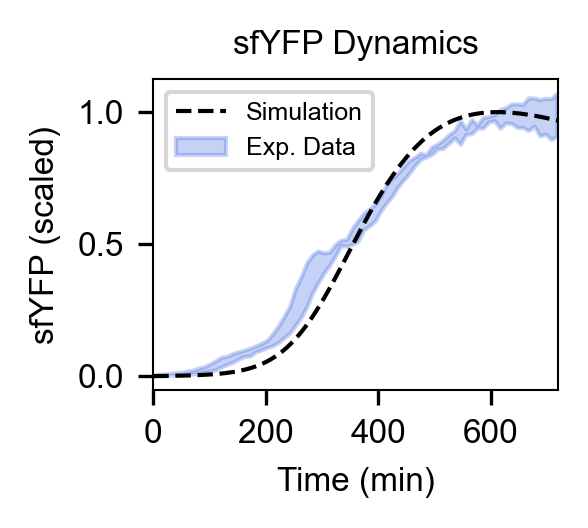

In [99]:
# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 6
})
tick_fontsize = 8

fig_size = 2,1.8
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region

# ===============================
# Compute means, stds, and bounds
# ===============================
min_length = min(len(B_non_leaky[0]), len(B_non_leaky[1]), len(B_non_leaky[2]))
B_non_leaky[0], B_non_leaky[1], B_non_leaky[2] = B_non_leaky[0][:min_length], B_non_leaky[1][:min_length], B_non_leaky[2][:min_length]
mean_exp_B = np.mean(B_non_leaky, axis=0)[:,0]/B_max
std_exp_B  = np.std(B_non_leaky, axis=0)[:,0]/B_max
upper_B, lower_B = mean_exp_B + std_exp_B, mean_exp_B - std_exp_B


fig, ax = plt.subplots(figsize=fig_size , dpi = 300)

# Model simulations 
ax.plot(
    results['time'], results['Pm'] / np.max(results['Pm']),
    '--', label="Simulation", color='black', linewidth=lwd
)
ax.fill_between(
    time_A[0][:tf_i], upper_B[:tf_i], lower_B[:tf_i],
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)


# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='upper left')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
plt.savefig('figures/sfYFP_no_degtag.png', dpi=300, bbox_inches='tight', transparent=True)

### Step 11: Compile the reaction network — generate reactions and (optionally) SBML

**What we'll do:** Generate reactions and (optionally) sbml.

**Why it matters:** Keeps the workflow explicit and reproducible.

In [100]:
## Construct the minimal single-scale model 

# Reaciton Objects
# r_tx_single_scale = Reaction.from_massaction([], [M], k_forward = beta_m.value)
# r_dm_single_scale = Reaction.from_massaction([M], [], k_forward = d_m.value)
# r_tl_single_scale = Reaction.from_massaction([M], [M, P], k_forward = k_tl.value)
# r_dp_single_scale = Reaction.from_massaction([P], [], k_forward = d_p.value)
# r_fold_single_scale = Reaction.from_massaction([P], [Pm], k_forward = k_fold.value)
# r_dp_Pm_single_scale = Reaction.from_massaction([Pm], [], k_forward = d_p.value)
dp_ss = 0.005
r_tx_single_scale = Reaction.from_massaction([], [M], k_forward = 100)
r_dm_single_scale = Reaction.from_massaction([M], [], k_forward = 0.1)
r_tl_single_scale = Reaction.from_massaction([M], [M, P], k_forward = 0.1)
r_dp_single_scale = Reaction.from_massaction([P], [], k_forward = dp_ss)
r_fold_single_scale = Reaction.from_massaction([P], [Pm], k_forward = 0.05)
r_dp_Pm_single_scale = Reaction.from_massaction([Pm], [], k_forward = dp_ss)

print("\nReactions can be printed as well:\n", r_tx_single_scale,"\n", r_dm_single_scale, "\n", r_tl_single_scale,
      "\n", r_dp_single_scale, "\n", r_fold_single_scale, "\n", r_dp_Pm_single_scale)

#create an initial condition so A has a non-zero value
initial_concentration_dict_single_scale = {M:0, P:0, Pm:0}

# Make a CRN
CRN_single_scale = ChemicalReactionNetwork(species = [M, P, Pm], reactions = [r_tx_single_scale, r_dm_single_scale, r_tl_single_scale,
                                                               r_dp_single_scale, r_fold_single_scale, r_dp_Pm_single_scale],
                              initial_concentration_dict = initial_concentration_dict_single_scale)



Reactions can be printed as well:
  --> M 
 M -->  
 M --> M+P 
 P -->  
 P --> Pm 
 Pm --> 


### Step 12: Compile the reaction network — generate reactions and (optionally) SBML

**What we'll do:** Generate reactions and (optionally) sbml.

**Why it matters:** Keeps the workflow explicit and reproducible.

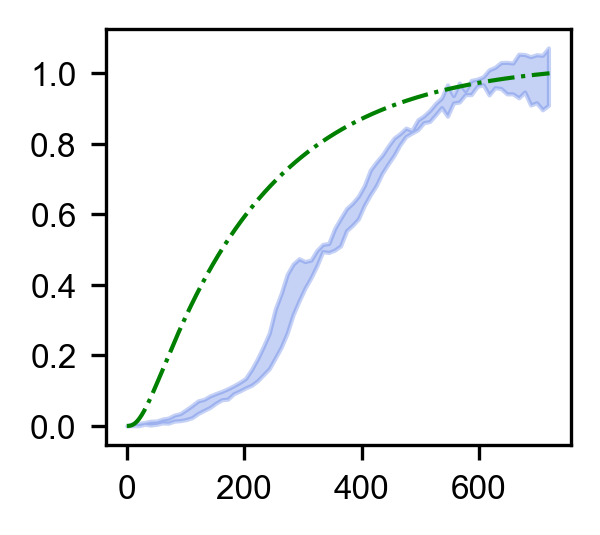

In [101]:
## Simulate with bioscrape (deterministic)
# This returns a pandas DataFrame with 'time' and species columns (by string name)
results_single_scale = CRN_single_scale.simulate_with_bioscrape_via_sbml(timepoints=timepoints, initial_condition_dict=initial_concentration_dict_single_scale)

# Plot Pm from single-scale model
fig, ax = plt.subplots(figsize=fig_size , dpi = 300)
ax.plot(
    results_single_scale['time'], results_single_scale['Pm'] / np.max(results_single_scale['Pm']),
    '-.', label="Single-scale Simulation", color='green', linewidth=lwd
)
ax.fill_between(
    time_A[0][:tf_i], upper_B[:tf_i], lower_B[:tf_i],
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)

### Step 13: Simulate the model — integrate ODEs over time with chosen solver

**What we'll do:** Integrate odes over time with chosen solver.

**Why it matters:** Keeps the workflow explicit and reproducible.

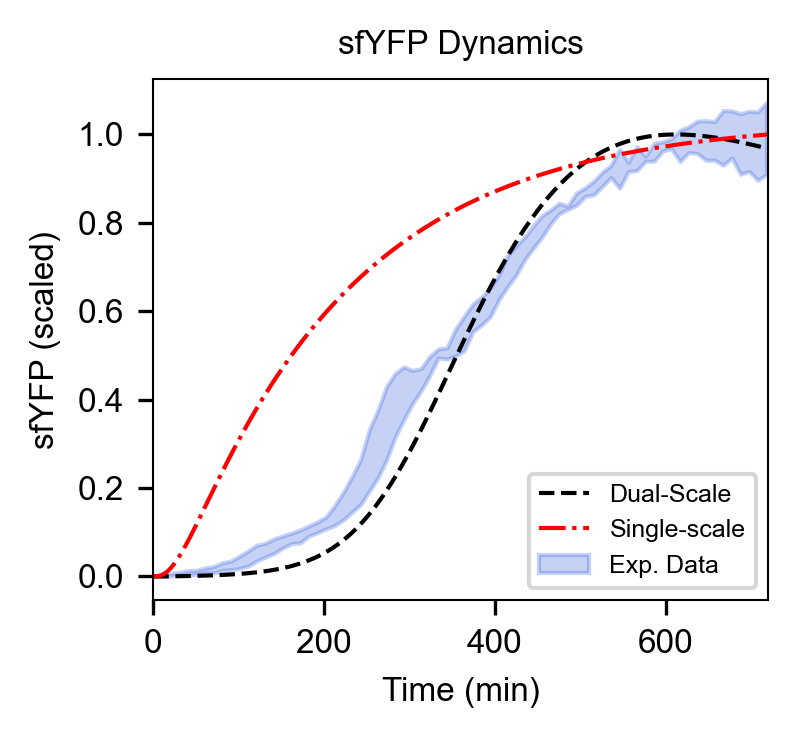

In [102]:
# Style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 6
})
tick_fontsize = 8

fig_size = 2.7,2.5
# exp_color = '#931a20'
exp_color = 'royalblue'

lwd = 1 # linewdith for plot
alpha_fill = 0.3 # alpha value for filling the std region

# ===============================
# Compute means, stds, and bounds
# ===============================
min_length = min(len(B_non_leaky[0]), len(B_non_leaky[1]), len(B_non_leaky[2]))
B_non_leaky[0], B_non_leaky[1], B_non_leaky[2] = B_non_leaky[0][:min_length], B_non_leaky[1][:min_length], B_non_leaky[2][:min_length]
mean_exp_B = np.mean(B_non_leaky, axis=0)[:,0]/B_max
std_exp_B  = np.std(B_non_leaky, axis=0)[:,0]/B_max
upper_B, lower_B = mean_exp_B + std_exp_B, mean_exp_B - std_exp_B


fig, ax = plt.subplots(figsize=fig_size , dpi = 300)

# Model simulations 
ax.plot(
    results['time'], results['Pm'] / np.max(results['Pm']),
    '--', label="Dual-Scale", color='black', linewidth=lwd
)

ax.plot(
    results_single_scale['time'], results_single_scale['Pm'] / np.max(results_single_scale['Pm']),
    '-.', label="Single-scale", color='red', linewidth=lwd
)

ax.fill_between(
    time_A[0][:tf_i], upper_B[:tf_i], lower_B[:tf_i],
    color=exp_color, alpha=alpha_fill, label='Exp. Data'
)


# Labels and axis limits
ax.set_xlabel('Time (min)')
ax.set_ylabel('sfYFP (scaled)')
ax.set_title('sfYFP Dynamics')
ax.set_xlim(0, 720)
ax.set_xticks([0, 200, 400, 600])
ax.legend(loc='lower right')


# Spine control
spine_width = 0.5
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(spine_width)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Layout and save
plt.tight_layout()
plt.savefig('figures/sfYFP_model_comparison.png', dpi=300, bbox_inches='tight', transparent=True)